In [5]:
import matplotlib.pyplot
import numpy.random
import torch.utils.data
import torchvision
from torch import Tensor
from torch.nn import Module
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Tutorial 1a. Logistic Regression

In the first tutorial, we are going to train a logistic regressor on the MNIST dataset of handwritten digits. Next, we will turn this logistic regressor into a non-linear convolutional network.

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    if torch.backends.mps.is_available():
        DEVICE = "mps"
    else:
        DEVICE = "cpu"

## Loading Datasets

The following code will load the MNIST dataset. Run it and inspect some of the images and their labels to confirm they are correct.

In [3]:
train_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=True,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=False,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=False,
)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

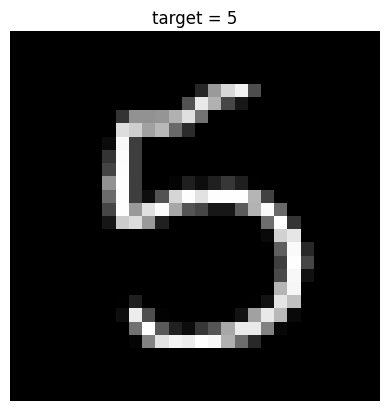

In [4]:
image, target = [*test_dataloader][0]

random_index = numpy.random.randint(0, 64)

image, target = image[random_index, 0], target[random_index]

matplotlib.pyplot.imshow(
    image, 
    cmap="gray", 
    interpolation="nearest",
)

matplotlib.pyplot.title(f"target = {target}")
matplotlib.pyplot.axis("off")

Next, we create a PyTorch dataloader for the MNIST dataset.

Next, implement a logistic regression model in PyTorch. Note that a logistic regressor uses a linear transformation of the input.


## Exercise 1. Logistic Regression Module

In [13]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size: int, num_classes: int):
        super().__init__()
        self.y = nn.Linear(input_size,num_classes)
#         ###########################################################################
#         # TODO: Instantiate the layer here.                                       #
#         ###########################################################################
# 
    def forward(self, x: Tensor) -> Tensor:
#         ###########################################################################
#         # TODO: Apply the layer to the input.                                     #
#         ###########################################################################
        return self.y(x)

In [14]:
module = LogisticRegression(28 * 28, 10)

module = module.to(device=DEVICE)

In [15]:
###########################################################################
# TODO: Create criterion and optimizer here.                              #
###########################################################################

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(module.parameters(),lr=0.01)

## Training

We will use the following generic training loop for a PyTorch model.

In [31]:
# Train the model. If everything is correct, the loss should go below 0.45.

EPOCHS = 5

# Exponential moving average of the loss:
ema = None

for epoch in range(EPOCHS):
    for batch_index, (train_images, train_targets) in enumerate(train_dataloader):
        train_images = train_images.view(-1, 28 * 28).requires_grad_().to(device=DEVICE)

        train_targets = train_targets.to(device=DEVICE)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = module(train_images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_targets)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updates parameters:
        optimizer.step()

        # NOTE: It is important to call .item() on the loss before summing.
        if ema is None:
            ema = loss.item()
        else:
            ema += (loss.item() - ema) * 0.01

        if batch_index % 500 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_index * len(train_images),
                    len(train_dataloader.dataset),
                    100.0 * batch_index / len(train_dataloader),
                    ema,
                ),
            )

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.274161
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.396450
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.390241
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.401359
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.402017
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.395085
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.400440
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.404319
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.406672
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.400679


**Question:** For the model you are currently using, is there any difference between using the model in `train` mode or using it in `eval` mode? 

Create an SGD optimizer and us it to train the logistic regressor on the MNIST training data for a few epochs. What loss function do you need to use?

For a simple logistic regression model (just a linear layer), there is **no difference** between `train()` and `eval()` mode, since it does not use dropout or batchnorm.

### Embeddings 

Visualize the weights of the trained model. What do you see? Why?

In [36]:
assert module.y.weight.shape == (10, 28 * 28)

(np.float64(-0.5), np.float64(151.5), np.float64(61.5), np.float64(-0.5))

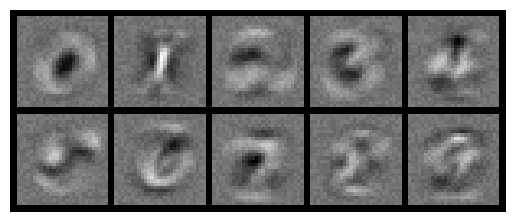

In [37]:
matplotlib.pyplot.imshow(
    numpy.transpose(
        torchvision.utils.make_grid(
            module.y.weight.view(10, 1, 28, 28).cpu(),
            normalize=True,
            nrow=5,
        ), 
        (1, 2, 0),
    ), 
    interpolation="nearest",
)

matplotlib.pyplot.grid(False)
matplotlib.pyplot.gca().axis("off")

## Evaluation

Use the following function to measure the test accuracy of your trained model.

In [21]:
correct_predictions = 0
predictions = 0

# Iterate through test dataset
for test_images, test_targets in test_dataloader:
    test_images = test_images.view(-1, 28 * 28).to(DEVICE)

    # Forward pass only to get logits/output
    outputs = module(test_images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    predictions += test_targets.size(0)

    if torch.backends.mps.is_available():
        correct_predictions += (predicted.cpu() == test_targets.cpu()).sum()
    else:
        correct_predictions += (predicted == test_targets).sum()

correct_predictions.item() / predictions

0.8989